In [1]:
import os
import cv2
import numpy as np
import pandas as pd

import inference_centernet as CenterNet
import inference_yolo as YOLO
import inference_synthetic as Dataset

from association import match,associate
from Painter import Painter
from tqdm import tqdm,trange

import matplotlib.pyplot as plt

import gc

In [16]:
name = 'general_eval_full'
max_img = 300

base_dir = '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/'
img_dirs = os.path.join(base_dir,name)
imgs_path = [os.path.join(img_dirs,x) for x in sorted(os.listdir(img_dirs))][:max_img]

painter = Painter(name=name)
painter.angle_ranges = 80

In [17]:
centernet_df = CenterNet.forward(img_dirs,max_img)
YOLO_df = YOLO.forward(img_dirs,max_img)
associated_df = associate(centernet_df,YOLO_df)

Fix size testing.
training chunk_sizes: [32]
The output will be saved to  /home/alfin/Documents/deep_learning/production/centernet_3d_fish/src/lib/../../exp/fish/default
heads {'hm': 1, 'reg': 2, 'dep': 1, 'dim': 3, 'rot': 2}
heads {'hm': 1, 'reg': 2, 'dep': 1, 'dim': 3, 'rot': 2}
Creating model...
loaded ../models/red_orbitting_3cam_output_3.pth, epoch 67


100%|███████████████████████████████████████████████████████████████████████| 300/300 [00:10<00:00, 29.27it/s]

    WARNING ⚠️ stream/video/webcam/dir predict source will accumulate results in RAM unless `stream=True` is passed,
    causing potential out-of-memory errors for large sources or long-running streams/videos.

    Usage:
        results = model(source=..., stream=True)  # generator of Results objects
        for r in results:
            boxes = r.boxes  # Boxes object for bbox outputs
            masks = r.masks  # Masks object for segment masks outputs
            probs = r.probs  # Class probabilities for classification outputs

100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 488.31it/s]


In [18]:
del centernet_df
del YOLO_df
gc.collect()

20

In [19]:
synthetic_df = Dataset.forward(img_dirs,max_img)

100%|██████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 783.26it/s]


In [20]:
eval_df = associate(associated_df,synthetic_df)

In [14]:
painter = Painter(name=name)
painter.angle_ranges = 80

data = eval_df

for idx in tqdm(sorted(data['idx'].unique())):
    path = imgs_path[int(idx)]
    
    label = data[data['idx']==idx]
    gt = synthetic_df[synthetic_df['idx']==idx]

    img = cv2.imread(path)
    painter.set_img(img)

    for i in range(len(label)):
        ann = label.copy().iloc[i]

        ann_gt = gt[gt['id'] == ann['id']]
        ann_gt = ann_gt.iloc[0]

        painter.set_label(ann)

        # if painter.perpendicular :
        painter.draw_3d_box()
        painter.draw_dashed_2d_box()
        painter.draw_size_label()
        painter.draw_size_acc_label(ann_gt)

#         xmin,ymin,xmax,ymax = painter.label.bbox

#         painter.img = cv2.rectangle(painter.img, (xmin,ymin), (xmax,ymin-5), painter.label.color,cv2.FILLED)
#         painter.img = cv2.putText(painter.img,str(painter.label.obj_id),(xmin,ymin), cv2.FONT_HERSHEY_PLAIN ,0.5,(255,255,255), 1, cv2.LINE_AA)


    painter.draw_fish_count(len(label))

    painter.update()

painter.save_video()
print('Video Saved Sucessfully!!')


100%|████████████████████████████████████████████████████████████████████| 1500/1500 [00:12<00:00, 122.62it/s]

Video Saved Sucessfully!!


In [15]:
pred_df = eval_df.copy()
gt_df = synthetic_df.copy()

In [16]:
res = []

In [17]:
for i in trange(len(pred_df)):
    pred = pred_df.iloc[i]
    gt = gt_df.iloc[i]
    
    error_w = abs(pred['w'] - gt['w'])
    error_h = abs(pred['h'] - gt['h'])
    error_l = abs(pred['l'] - gt['l'])
    
    acc_w = np.round((1 - error_w/pred['w'])*100,1)
    acc_h = np.round((1 - error_h/pred['h'])*100,1)
    acc_l = np.round((1 - error_l/pred['l'])*100,1)
    
    data = pred.values.tolist() + [error_w,error_h,error_l,acc_w,acc_h,acc_l]
    res.append(data)

100%|███████████████████████████████████████████████████████████████████| 8842/8842 [00:01<00:00, 8655.43it/s]


In [25]:
out_columns = ['h','l','w','z','alphax','alphay','conf','idx','cx','cy','xmin','ymin','xmax','ymax','id','error_w','error_h','error_l','acc_w','acc_h','acc_l']
acc_df = pd.DataFrame(res,columns=out_columns)

acc_df = acc_df[acc_df['id']==9]

In [26]:
df = acc_df.copy()
df['alphax'] = np.degrees(df['alphax'])
df['alphay'] = np.degrees(df['alphay'])

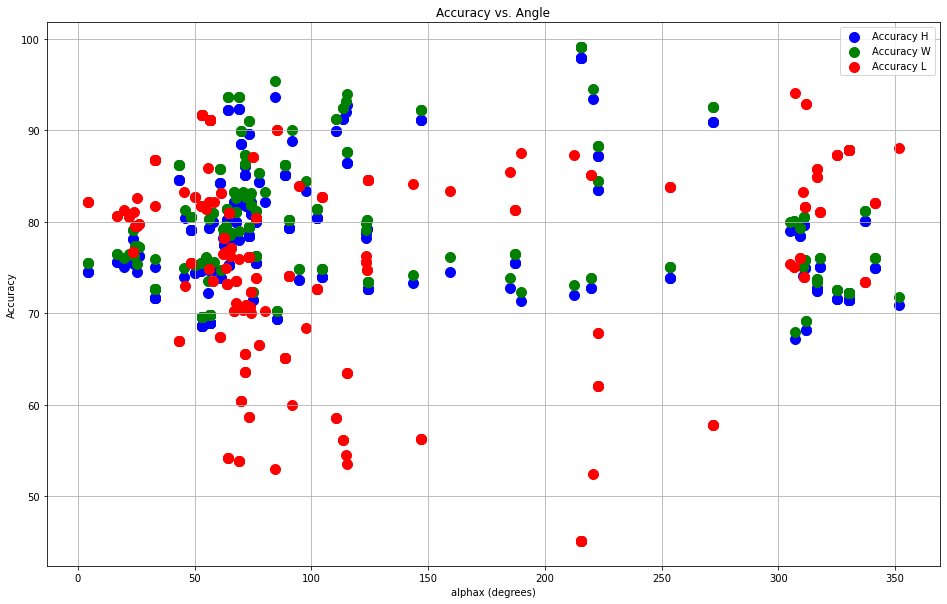

In [28]:
# Plotting the data
plt.figure(figsize=(16, 10)) 

plt.scatter(df['alphax'], df['acc_h'], marker='o',s=100, color='b', label='Accuracy H')
plt.scatter(df['alphax'], df['acc_w'], marker='o',s=100, color='g', label='Accuracy W')
plt.scatter(df['alphax'], df['acc_l'], marker='o',s=100, color='r', label='Accuracy L')

# plt.plot(df['alphax'], df['acc_h'], marker='o', color='b', label='Accuracy H')
# plt.plot(df['alphax'], df['acc_w'], marker='o', color='g', label='Accuracy W')
# plt.plot(df['alphax'], df['acc_l'], marker='o', color='r', label='Accuracy L')

plt.xlabel('alphax (degrees)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Angle')
plt.legend()
plt.grid(True)
plt.show()

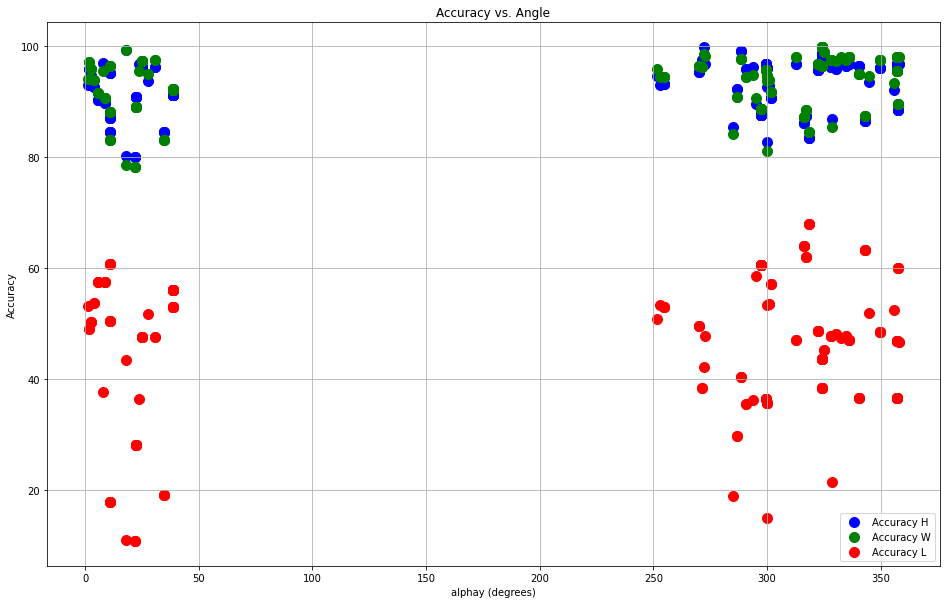

In [24]:
# Plotting the data
plt.figure(figsize=(16, 10)) 

plt.scatter(df['alphay'], df['acc_h'], marker='o',s=100, color='b', label='Accuracy H')
plt.scatter(df['alphay'], df['acc_w'], marker='o',s=100, color='g', label='Accuracy W')
plt.scatter(df['alphay'], df['acc_l'], marker='o',s=100, color='r', label='Accuracy L')

# plt.plot(df['alphax'], df['acc_h'], marker='o', color='b', label='Accuracy H')
# plt.plot(df['alphax'], df['acc_w'], marker='o', color='g', label='Accuracy W')
# plt.plot(df['alphax'], df['acc_l'], marker='o', color='r', label='Accuracy L')

plt.xlabel('alphay (degrees)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Angle')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
df = eval_df

In [26]:
df[df['id']==2].reset_index(drop=True)
# This is the converted data

,h,l,w,z,alphax,alphay,conf,idx,cx,cy,xmin,ymin,xmax,ymax,id
0,0.146239,0.066719,0.335823,1.144037,3.625512,4.275823,1.0,1.0,223.0,194.0,200.0,135.0,249.0,235.0,2.0
1,0.140613,0.064112,0.322954,1.089005,3.803219,4.289317,1.0,2.0,222.0,199.0,199.0,140.0,248.0,240.0,2.0
2,0.144554,0.065827,0.331754,1.060928,3.671881,4.254036,1.0,3.0,222.0,204.0,197.0,145.0,247.0,244.0,2.0
3,0.144554,0.065827,0.331754,1.060928,3.671881,4.254036,1.0,4.0,221.0,208.0,195.0,150.0,247.0,249.0,2.0
4,0.144554,0.065827,0.331754,1.060928,3.671881,4.254036,1.0,5.0,220.0,213.0,194.0,155.0,246.0,254.0,2.0
5,0.144554,0.065827,0.331754,1.060928,3.671881,4.254036,1.0,6.0,220.0,218.0,193.0,160.0,245.0,259.0,2.0
6,0.144554,0.065827,0.331754,1.060928,3.671881,4.254036,1.0,7.0,219.0,222.0,192.0,166.0,245.0,264.0,2.0
7,0.133149,0.060581,0.305762,1.049332,3.690385,4.241615,1.0,8.0,218.0,227.0,191.0,170.0,245.0,269.0,2.0
8,0.133149,0.060581,0.305762,1.049332,3.690385,4.241615,1.0,9.0,218.0,232.0,189.0,175.0,246.0,273.0,2.0
9,0.122364,0.055723,0.280620,1.071194,4.278033,4.357143,1.0,10.0,217.0,236.0,189.0,180.0,246.0,278.0,2.0
